# 贝叶斯优化XGBoost
- 融合了贝叶斯与XGBoost  
- 创新点在于构造新变量
- 条件赋值

## 1 数据导入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from scipy.stats import rankdata

# 数据导入
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


## 2 构造变量

In [2]:
# 构造新变量
for df in [train, test]:
    df['temp_change_rate'] = df['temparature'].diff().fillna(0)
    df['humidity_change_trend'] = df['humidity'].diff().fillna(0)

RMV = ['rainfall','id']
FEATURES = [c for c in train.columns if c not in RMV]

## 3 贝叶斯优化
### 3.1 定义贝叶斯优化函数

In [3]:
# 贝叶斯优化函数
def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda):
    """贝叶斯优化目标函数"""
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'n_estimators': 10000,
        'eval_metric': 'auc',
        'early_stopping_rounds': 80
    }
    
    cv_scores = []
    train_auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(train):
        x_train = train.loc[train_idx, FEATURES]
        y_train = train.loc[train_idx, 'rainfall']
        x_val = train.loc[val_idx, FEATURES]
        y_val = train.loc[val_idx, 'rainfall']
        
        model = XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            verbose=False
        )
        
        train_pred = model.predict_proba(x_train)[:, 1]
        val_pred = model.predict_proba(x_val)[:, 1]
        
        train_auc = roc_auc_score(y_train, train_pred)
        val_auc = roc_auc_score(y_val, val_pred)
        
        cv_scores.append(val_auc)
        train_auc_scores.append(train_auc)
    
    # 计算过拟合指标
    mean_train_auc = np.mean(train_auc_scores)
    mean_val_auc = np.mean(cv_scores)
    overfit_gap = mean_train_auc - mean_val_auc
    print(f"Train AUC = {mean_train_auc:.3f}, Val AUC = {mean_val_auc:.3f}, Overfitting = {overfit_gap:.3f}")
    
    # # 如果过拟合严重（训练AUC比验证高0.05以上），惩罚最终得分
    # if overfit_gap > 0.05:
    #     return mean_val_auc * 0.9  # 对过拟合的参数组合进行惩罚
    # elif overfit_gap > 0.1:
    #     return mean_val_auc * 0.8
    
    return mean_val_auc

### 3.2 运行贝叶斯优化

In [4]:
# 定义参数空间
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.8, 1),
    'colsample_bytree': (0.8, 1),
    'gamma': (0, 1),
    'reg_alpha': (0.1, 1),
    'reg_lambda': (0.1, 1)
}

# 运行贝叶斯优化
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=100, n_iter=300)

# 获取最佳参数
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
print('最佳参数:', best_params)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
Train AUC = 0.992, Val AUC = 0.894, Overfitting = 0.098
| 1         | 0.8942    | 0.8749    | 0.9507    | 0.2223    | 7.191     | 0.2404    | 0.2404    | 0.8116    |
Train AUC = 0.933, Val AUC = 0.896, Overfitting = 0.037
| 2         | 0.8959    | 0.9732    | 0.6011    | 0.2153    | 3.144     | 0.9729    | 0.8492    | 0.8425    |
Train AUC = 0.968, Val AUC = 0.891, Overfitting = 0.077
| 3         | 0.891     | 0.8364    | 0.1834    | 0.09823   | 6.673     | 0.4888    | 0.3621    | 0.9224    |
Train AUC = 0.981, Val AUC = 0.893, Overfitting = 0.087
| 4         | 0.8934    | 0.8279    | 0.2921    | 0.1162    | 6.192     | 0.8067    | 0.2797    | 0.9028    |
Train AUC = 0.945, Val AUC = 0.894, Overfitting = 0.051
| 5         | 0.8938    | 0.9185    | 0.04645   | 0.1862    

## 4 交叉验证

In [5]:
# 5折交叉验证预测
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

fold_train_auc = []
fold_val_auc = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, "rainfall"]
    x_valid = train.loc[test_index, FEATURES]
    y_valid = train.loc[test_index, "rainfall"]
    x_test = test[FEATURES]

    model = XGBClassifier(
        **best_params,
        n_estimators=10000,
        early_stopping_rounds=80,
        eval_metric='auc'
    )
    
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )
    
    # 记录训练集预测结果
    train_pred = model.predict_proba(x_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_pred)
    
    # 验证集预测
    val_pred = model.predict_proba(x_valid)[:, 1]
    val_auc = roc_auc_score(y_valid, val_pred)
    
    # 存储结果
    oof_xgb[test_index] = val_pred
    fold_train_auc.append(train_auc)
    fold_val_auc.append(val_auc)
    
    # 测试集预测
    pred_xgb += model.predict_proba(x_test)[:, 1]

pred_xgb /= FOLDS
sample = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sample.rainfall = pred_xgb
sample.to_csv("submission_without_ensemble.csv",index=False)
print(sample.head())

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.83254
[95]	validation_0-auc:0.86831
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.82318
[94]	validation_0-auc:0.87472
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.87687
[98]	validation_0-auc:0.89737
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.90793
[88]	validation_0-auc:0.90933
#########################
### Fold 5
#########################
[0]	validation_0-auc:0.84747
[97]	validation_0-auc:0.86768
     id  rainfall
0  2190  0.972205
1  2191  0.971208
2  2192  0.916424
3  2193  0.111176
4  2194  0.116295


## 5 过拟合分析


Average Training AUC:   0.9283
Average Validation AUC: 0.8993
Overfitting Gap:        0.0290

ℹ️ 注意：检测到中度过拟合
考虑进行适度的正则化或降低复杂度


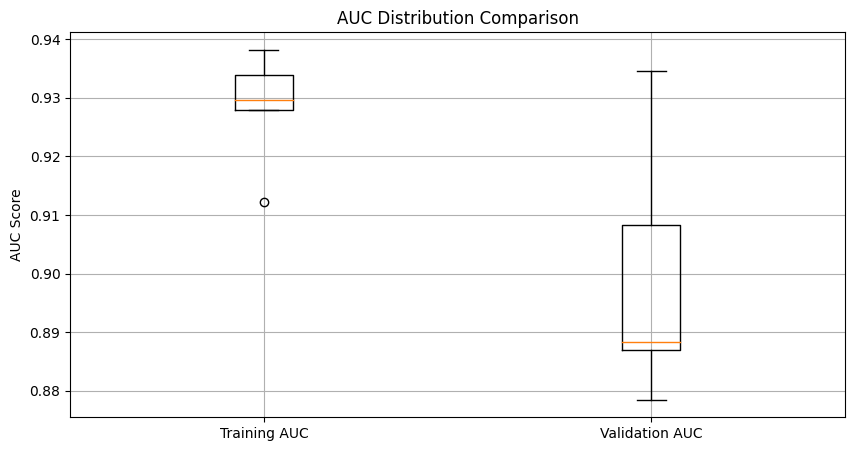

In [6]:
# 过拟合分析
mean_train_auc = np.mean(fold_train_auc)
mean_val_auc = np.mean(fold_val_auc)
overfit_gap = mean_train_auc - mean_val_auc

print("\n" + "="*50)
print(f"Average Training AUC:   {mean_train_auc:.4f}")
print(f"Average Validation AUC: {mean_val_auc:.4f}")
print(f"Overfitting Gap:        {overfit_gap:.4f}")

if overfit_gap > 0.05:
    print("\n⚠️ 警告：检测到严重过拟合！")
    print("建议操作：")
    print("- 增加正则化系数（reg_alpha/reg_lambda）")
    print("- 降低模型复杂度（max_depth）")
    print("- 增加更多训练数据")
    print("- 进行特征选择")
elif overfit_gap > 0.02:
    print("\nℹ️ 注意：检测到中度过拟合")
    print("考虑进行适度的正则化或降低复杂度")
else:
    print("\n✅ 模型表现出良好的泛化性能")

# 可视化训练与验证AUC分布
plt.figure(figsize=(10, 5))
plt.boxplot([fold_train_auc, fold_val_auc], 
           labels=['Training AUC', 'Validation AUC'])
plt.title("AUC Distribution Comparison")
plt.ylabel("AUC Score")
plt.grid(True)
plt.show()

## 6 Ensemble

In [7]:
# 集成结果并保存最终结果
best_public = pd.read_csv("/kaggle/input/0-96245-lda-lgs-ensemble-for-rainfall-pred/submission.csv")
best_public = best_public.rainfall.values

sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -0.05 * rankdata( pred_xgb ) + 1.05 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)

# 进行条件赋值
sub['rainfall'] = sub['rainfall'].apply(lambda x: 1 if x > 0.95 else 0 if x < 0.05 else x)

# 保存结果
sub.to_csv(f"submission_ensemble.csv",index=False)
print(sub.head())

     id  rainfall
0  2190  1.000000
1  2191  1.000000
2  2192  1.000000
3  2193  0.106849
4  2194  0.000000
